<a href="https://colab.research.google.com/github/rawnakwow/CSE366/blob/main/Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import math
import matplotlib.pyplot as plt

In [2]:
def argmaxall(gen):
    """Returns a list of all elements with the maximal value from the generator."""
    maxv = -math.inf
    maxvals = []
    for (e, v) in gen:
        if v > maxv:
            maxvals, maxv = [e], v
        elif v == maxv:
            maxvals.append(e)
    return maxvals

In [3]:
def argmaxe(gen):
    """Returns an element with the maximal value from the generator, chosen randomly if there are multiple."""
    return random.choice(argmaxall(gen))

In [4]:
def select_from_dist(item_prob_dist):
    """Returns a value from a probability distribution."""
    ranreal = random.random()
    cumulative_prob = 0.0
    for (it, prob) in item_prob_dist.items():
        cumulative_prob += prob
        if ranreal < cumulative_prob:
            return it
    raise RuntimeError(f"{item_prob_dist} is not a probability distribution")

In [5]:
class Displayable(object):
    """Class that uses 'display'."""
    max_display_level = 1   # can be overridden in subclasses or instances

    def display(self, level, *args, **nargs):
        """Print the arguments if level is less than or equal to the current max_display_level."""
        if level <= self.max_display_level:
            print(*args, **nargs)

In [6]:
class Plot_history(object):
    """Set up the plot for the history of price and number in stock."""
    def __init__(self, ag, env):
        self.ag = ag
        self.env = env
        plt.ion()  # interactive mode for real-time plotting
        plt.xlabel("Time")
        plt.ylabel("Value")

    def plot_env_hist(self):
        """Plot history of price and stock."""
        num = len(self.env.stock_history)
        plt.plot(range(num), self.env.price_history, label="Price")
        plt.plot(range(num), self.env.stock_history, label="In stock")
        plt.legend()

    def plot_agent_hist(self):
        """Plot history of buying."""
        num = len(self.ag.buy_history)
        plt.bar(range(1, num + 1), self.ag.buy_history, label="Bought")
        plt.legend()

In [7]:
class Agent(Displayable):
    def initial_action(self, percept):
        """Return the initial action."""
        return self.select_action(percept)  # same as select_action

    def select_action(self, percept):
        """Return the next action (and update internal state) given percept."""
        raise NotImplementedError("go")  # abstract method

In [8]:
class Environment(Displayable):
    def initial_percept(self):
        """Returns the initial percept for the agent."""
        raise NotImplementedError("initial_percept")  # abstract method

    def do(self, action):
        """Does the action (buy) and returns the next percept."""
        raise NotImplementedError("Environment.do")  # abstract method

In [9]:
class Simulate(Displayable):
    """Simulate the interaction between the agent and the environment for n time steps."""
    def __init__(self, agent, environment):
        self.agent = agent
        self.env = environment
        self.percept = self.env.initial_percept()
        self.percept_history = [self.percept]
        self.action_history = []

    def go(self, n):
        for i in range(n):
            action = self.agent.select_action(self.percept)
            print(f"i={i} action={action}")
            self.percept = self.env.do(action, i)
            print(f"      percept={self.percept}")

In [10]:
class SmartphoneEnv(Environment):
    price_delta = [0, 0, 0, 21, 0, 20, 0, -64, 0, 0, 23, 0, 0, 0, -35,
                  0, 76, 0, -41, 0, 0, 0, 21, 0, 5, 0, 5, 0, 0, 0, 5, 0, -15, 0, 5,
                  0, 5, 0, -115, 0, 115, 0, 5, 0, -15, 0, 5, 0, 5, 0, 0, 0, 5, 0,
                  -59, 0, 44, 0, 5, 0, 5, 0, 0, 0, 5, 0, -65, 50, 0, 5, 0, 5, 0, 0,
                  0, 5, 0]
    sd = 5  # noise standard deviation

    def __init__(self):
        self.time = 0
        self.stock = 20
        self.stock_history = []  # memory of the stock history
        self.price_history = []  # memory of the price history

    def initial_percept(self):
        """Return initial percept."""
        self.stock_history.append(self.stock)
        self.price = round(234 + self.sd * random.gauss(0, 1))
        self.price_history.append(self.price)
        return {'price': self.price, 'instock': self.stock}

    def do(self, action, time_unit):
        """Performs the action (buy) and returns percept consisting of price and instock."""
        used = select_from_dist({6: 0.1, 5: 0.1, 4: 0.1, 3: 0.3, 2: 0.2, 1: 0.2})
        bought = action['buy']
        self.stock = self.stock + bought - used
        self.stock_history.append(self.stock)
        self.time += 1
        self.price = round(self.price + self.price_delta[self.time % len(self.price_delta)]
                           + self.sd * random.gauss(0, 1))  # price fluctuates
        self.price_history.append(self.price)
        return {'price': self.price, 'instock': self.stock}

In [11]:
class SmartphoneAgent(Agent):
    def __init__(self):
        self.spent = 0
        percept = env.initial_percept()
        self.ave = self.last_price = percept['price']
        self.instock = percept['instock']
        self.buy_history = []

    def select_action(self, percept):
        """Returns next action to carry out."""
        self.last_price = percept['price']
        self.ave = self.ave + (self.last_price - self.ave) * 0.05  # smooth average
        self.instock = percept['instock']
        if self.last_price < 0.8 * self.ave and self.instock < 60:
            tobuy = 48  # order 48 units if price is 20% below average and stock is below 60
        elif self.instock < 12:
            tobuy = 12  # order 12 units if stock is below 12
        else:
            tobuy = 0  # no order if none of the conditions are met
        self.spent += tobuy * self.last_price
        self.buy_history.append(tobuy)
        return {'buy': tobuy}

i=0 action={'buy': 0}
      percept={'price': 238, 'instock': 19}
i=1 action={'buy': 0}
      percept={'price': 241, 'instock': 15}
i=2 action={'buy': 0}
      percept={'price': 261, 'instock': 12}
i=3 action={'buy': 0}
      percept={'price': 260, 'instock': 6}
i=4 action={'buy': 12}
      percept={'price': 276, 'instock': 14}
i=5 action={'buy': 0}
      percept={'price': 281, 'instock': 8}
i=6 action={'buy': 12}
      percept={'price': 213, 'instock': 19}
i=7 action={'buy': 0}
      percept={'price': 217, 'instock': 18}
i=8 action={'buy': 0}
      percept={'price': 219, 'instock': 12}
i=9 action={'buy': 0}
      percept={'price': 244, 'instock': 7}
Average spent per time step: 649.2


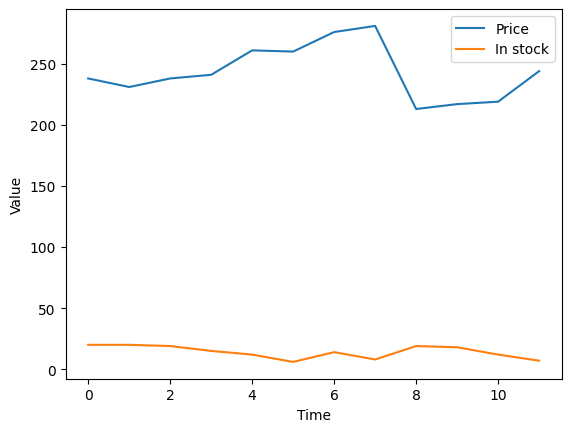

In [12]:
# Initialize environment and agent
env = SmartphoneEnv()
ag = SmartphoneAgent()

# Simulate the environment and agent interaction
sim = Simulate(ag, env)
sim.go(10)  # Simulate for 10 time steps

# Display the results
print(f"Average spent per time step: {ag.spent / env.time}")

# Plot the results
plot_history = Plot_history(ag, env)
plot_history.plot_env_hist()
plt.show()  # Show the plot